# Advanced Lane Finding Project

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ImageProcessing.process as proc
import imp

%matplotlib inline

import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

Use 9x6 grid to find image points.

In [2]:
nx, ny = 9, 6

Create the object points.

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Find the 2D image points of the chessboard

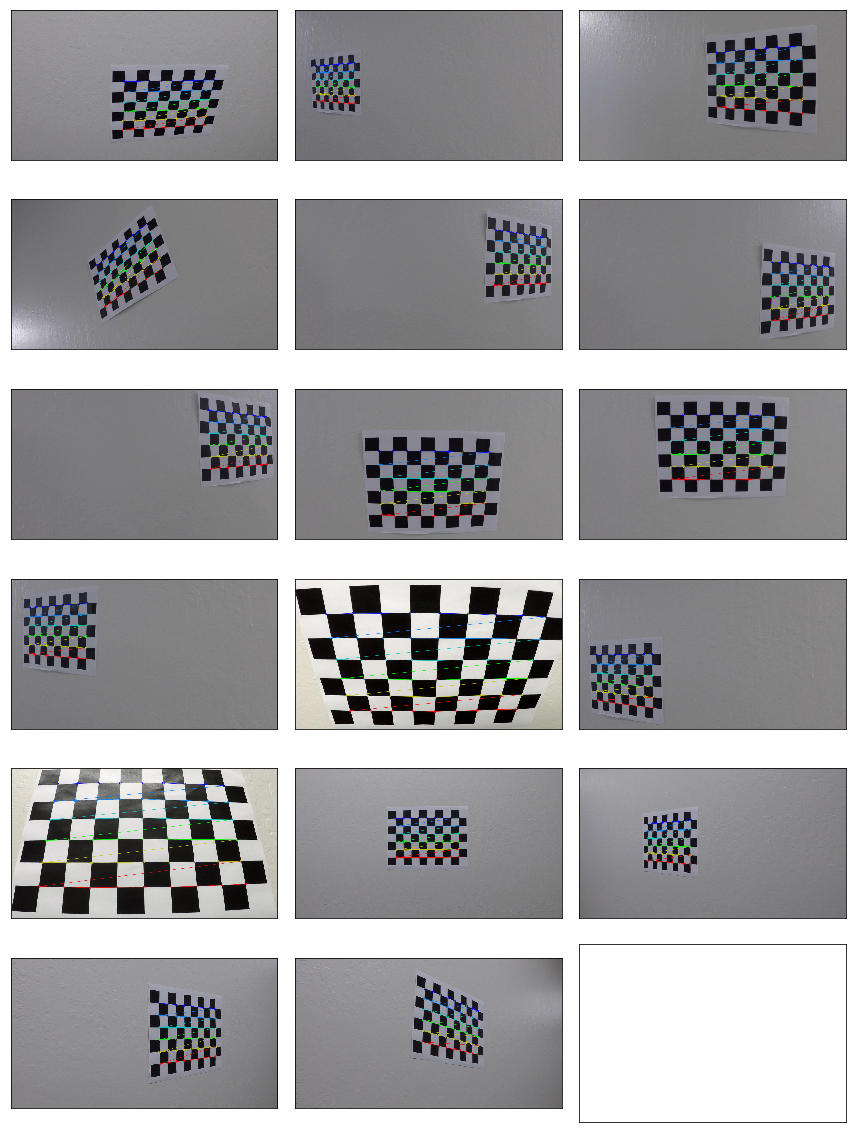

In [4]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12,16), subplot_kw={'xticks': [], 'yticks': []})

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = sorted(glob.glob('camera_cal/calibration*.jpg'))

# Step through the list and search for chessboard corners
count = 0
for fname in images[1:]:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        ax[count//3][count%3].imshow(img)
        
        count += 1
plt.tight_layout()

### Calibrate and Undistort a Test Image

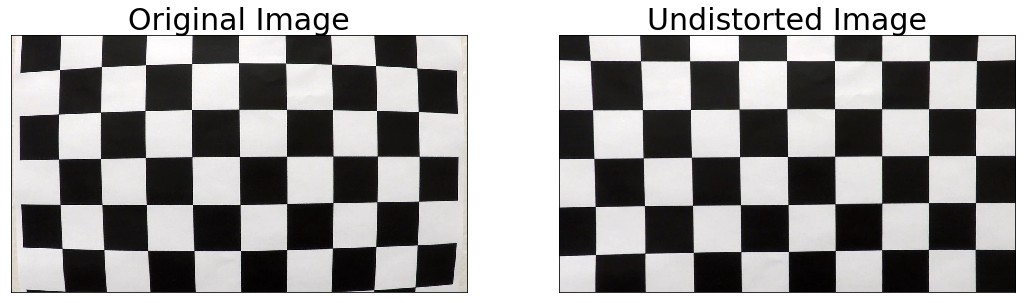

In [5]:
img = mpimg.imread(images[0])

# Do camera calibration given object points and image points
mtx, dist = proc.calibrate(img, objpoints, imgpoints)
dst = proc.undist(img, mtx, dist)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6), 
                             subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30);

## Pipeline

### Undistort Image

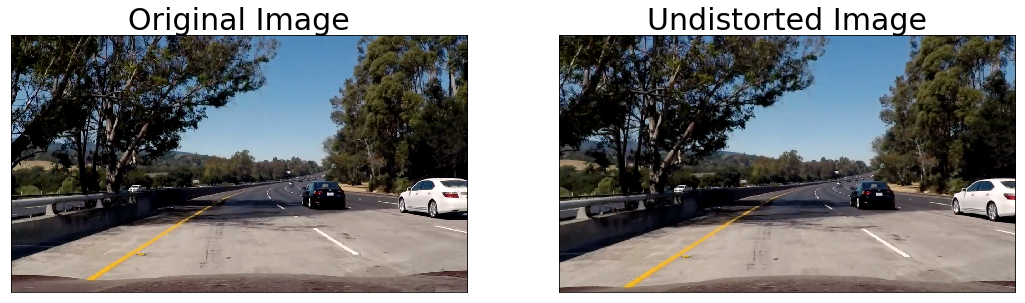

In [22]:
img = mpimg.imread('test_images/test5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6), 
                             subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(proc.undist(img, mtx, dist))
ax2.set_title('Undistorted Image', fontsize=30);

### Creating Thresholded Image

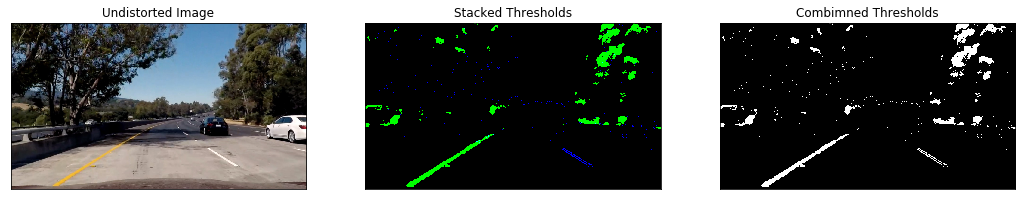

In [87]:
test_img = mpimg.imread('test_images/test5.jpg')
test_img = proc.undist(test_img, mtx, dist)

fig, ax = plt.subplots(1, 3, figsize=(18,4), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(test_img)
ax[0].set_title('Undistorted Image')

imp.reload(proc)

combined, color_binary = proc.thresholding(test_img, {}, {'b_chn_thresh': (145, 255)})

ax[1].imshow(color_binary)
ax[1].set_title('Stacked Thresholds')

ax[2].imshow(combined, cmap='gray')
ax[2].set_title('Combimned Thresholds');

### Perspective Transform

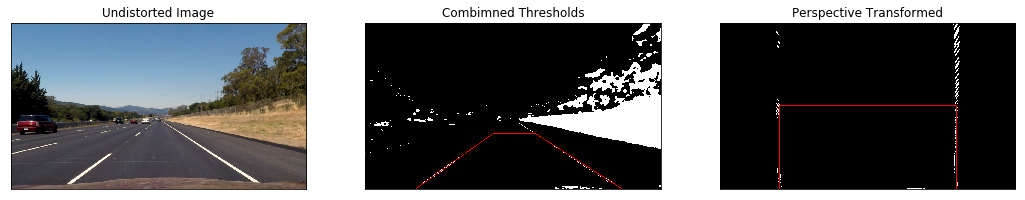

In [90]:
test_img = mpimg.imread('test_images/straight_lines2.jpg')
test_img = proc.undist(test_img, mtx, dist)

imp.reload(proc)

fig, ax = plt.subplots(1, 3, figsize=(18,4), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(test_img)
ax[0].set_title('Undistorted Image')

combined, color_binary = proc.thresholding(test_img, {}, {'b_chn_thresh': (145, 255)})
img = np.dstack((combined, combined, combined)) * 255
cv2.polylines(img, [np.r_[SRC, SRC[[0]]].astype(np.int32).reshape((-1,1,2))], 
              False, (255,0,0), thickness=2)
ax[1].imshow(img)
ax[1].set_title('Combimned Thresholds')

h, w = test_img.shape[:2]

SRC = np.array([[1.7 * w // 10, h], [8.7 * w // 10, h], [5.75 * w // 10, h - h // 3], 
                    [4.33 * w // 10, h - h // 3]])
DST = np.array([[2 * w // 10, h], [8 * w // 10, h], [8 * w // 10, h // 2], 
                    [2 * w // 10, h // 2]])

warped, M, Minv = proc.perspective_transform(combined, SRC, DST)
img = np.dstack((warped, warped, warped)) * 255
cv2.rectangle(img, tuple(DST[0]), tuple(DST[2]), (255,0,0), thickness=3)

ax[2].imshow(img)
ax[2].set_title('Perspective Transformed');

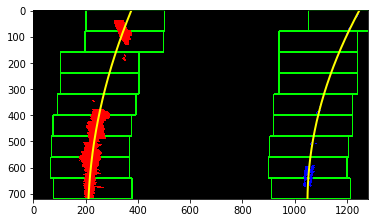

In [88]:
warped, M, Minv = proc.perspective_transform(combined, SRC, DST)
return_vars, outimg = proc.scan_find_lane(warped, margin=150)

plt.imshow(outimg)
plt.plot(return_vars['left_fit_x'], return_vars['fit_y'], c='yellow', lw=2)
plt.plot(return_vars['right_fit_x'], return_vars['fit_y'], c='yellow', lw=2);

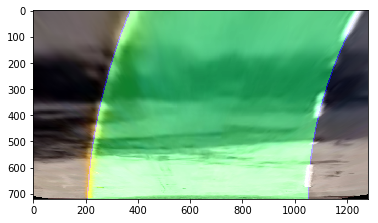

In [89]:
imp.reload(proc)
plt.imshow(proc.drawPoly(cv2.warpPerspective(test_img, M, test_img.shape[1::-1], flags=cv2.INTER_LINEAR), 
              return_vars['left_fit_x'], return_vars['fit_y'], return_vars['right_fit_x'], return_vars['fit_y']))

In [726]:
[np.hstack([return_vars['left_fit_x'],return_vars['right_fit_x']]).reshape(-1,1,2)].shape

AttributeError: 'list' object has no attribute 'shape'

In [749]:
tmp_img = np.zeros_like(test_img)
left_pts = np.c_[return_vars['left_fit_x'], return_vars['fit_y']].astype(np.int32)
right_pts = np.c_[return_vars['right_fit_x'], return_vars['fit_y']].astype(np.int32)
tmp_img = cv2.fillPoly(tmp_img, [np.hstack([left_pts, right_pts]).reshape((-1,1,2))], [122, 122, 122]);

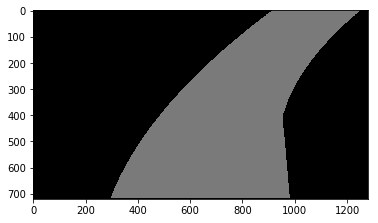

In [750]:
plt.imshow(tmp_img)

In [740]:
tmp_img.reshape((720,1280,1)).shape

(720, 1280, 1)

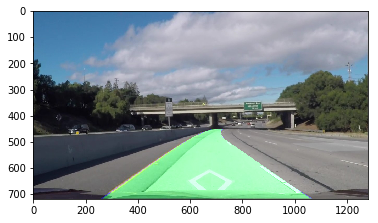

In [700]:
plt.imshow(proc.drawPoly(test_img, 
              return_vars['left_fit_x'], return_vars['fit_y'], return_vars['right_fit_x'], return_vars['fit_y'], M=Minv))

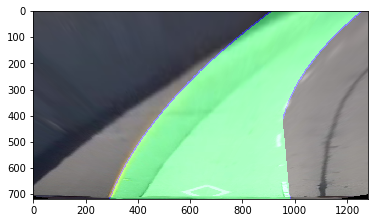

In [621]:
plt.imshow(proc.drawPoly(cv2.warpPerspective(test_img, M, test_img.shape[1::-1], flags=cv2.INTER_LINEAR), 
              curve['left_x'], curve['y'], curve['right_x'], curve['y']))

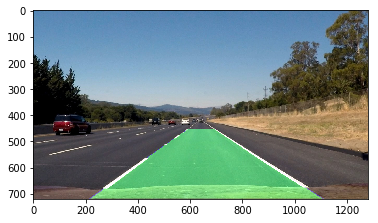

In [394]:
plt.imshow(proc.drawPoly(test_img, 
              curve['left_x'], curve['y'], curve['right_x'], curve['y'], M=Minv))

In [18]:
imp.reload(proc)

def pipeline(img):
    l_found = r_found = False
    img = proc.undist(img, mtx, dist)
    
    for i in range(2):
        if i == 0:
            # default: fine lines from original image
            combined = proc.thresholding(img, {}, {})[0]
        else:
            # find lines from histogram equalized image
            combined = proc.thresholding(np.dstack([cv2.equalizeHist(img[:,:,0]), 
                                                cv2.equalizeHist(img[:,:,1]),
                                                cv2.equalizeHist(img[:,:,2])]), {}, {'b_chn_thresh':(135, 255)})[0]
        try:
            warped = cv2.warpPerspective(combined, pipeline.M, pipeline.img_size, flags=cv2.INTER_LINEAR)
            
        except AttributeError:
            h, w = img.shape[0], img.shape[1]
            pipeline.img_size = (w, h)
            
            src_pts = np.array([[1.7 * w // 10, h], [8.7 * w // 10, h], [5.75 * w // 10, h - h // 3],
                                [4.33 * w // 10, h - h // 3]])
            dst_pts = np.array([[2 * w // 10, h], [8 * w // 10, h], [8 * w // 10, h // 2], 
                                [2 * w // 10, h // 2]])
            
            warped, M, Minv = proc.perspective_transform(combined, src_pts, dst_pts)
            pipeline.M = M
            pipeline.Minv = Minv
            
            pipeline.left_lane = proc.Line(sample_window=5, margin=100)
            pipeline.right_lane = proc.Line(sample_window=5, margin=100)
                
        if pipeline.left_lane.detected and pipeline.right_lane.detected and \
            len(pipeline.left_lane.recent_x_fitted) != 0 and len(pipeline.right_lane.recent_x_fitted) != 0:
            warped[(pipeline.left_lane.mask(img) != 1) & (pipeline.right_lane.mask(img) != 1)] = 0            
            
        if pipeline.left_lane.detected and pipeline.right_lane.detected:
            y_pts = np.linspace(0, pipeline.img_size[1]-1, pipeline.img_size[1])
            left_pts = np.c_[pipeline.left_lane.current_x_fitted, y_pts].astype(np.int32)
            right_pts = np.c_[pipeline.right_lane.current_x_fitted, y_pts].astype(np.int32)
            
            warped = cv2.polylines(warped, [left_pts.reshape((-1,1,2))], isClosed=False, color=(255), thickness=2)
            warped = cv2.polylines(warped, [right_pts.reshape((-1,1,2))], isClosed=False, color=(255), thickness=2)           
       
        return_vars, outimg = proc.scan_find_lane(warped, margin = 150)
        
        if return_vars['left_found']:
            if len(pipeline.left_lane.recent_x_fitted) == 0 or \
                    pipeline.left_lane.sanity_check(return_vars['left_fit_x']):
                #if len(pipeline.left_lane.recent_x_fitted) != 0:
                #    print('left', np.max(np.abs(pipeline.left_lane.current_x_fitted - return_vars['left_fit_x'])))
                l_found = True
                
        elif i == 1:
            pipeline.left_lane.detected = False
        
        if return_vars['right_found']:
            if len(pipeline.right_lane.recent_x_fitted) == 0 or \
                    pipeline.right_lane.sanity_check(return_vars['right_fit_x']):
                #if len(pipeline.right_lane.recent_x_fitted) != 0:
                #    print('right', np.max(np.abs(pipeline.right_lane.current_x_fitted - return_vars['right_fit_x'])))
                r_found = True
                
        elif i == 1:
            pipeline.right_lane.detected = False
            
        if l_found and r_found:
            poly_out = proc.drawPoly(img, return_vars['left_fit_x'], return_vars['fit_y'], 
                                     return_vars['right_fit_x'], return_vars['fit_y'], M=pipeline.Minv)    
            out = proc.addText(poly_out, return_vars['left_curverad'], return_vars['right_curverad'], 
                               M=pipeline.Minv)
            
            pipeline.left_lane.update(True, return_vars['left_fit_x'], return_vars['left_fit_eq'], 
                                      return_vars['left_curverad'])
            pipeline.right_lane.update(True, return_vars['right_fit_x'], return_vars['right_fit_eq'], 
                                       return_vars['right_curverad'])
            out = cv2.resize(out,None,fx=0.66, fy=0.66, interpolation = cv2.INTER_AREA)
            return out
        elif i == 1:  
            y_pts = np.linspace(0, pipeline.img_size[1]-1, pipeline.img_size[1])
            poly_out = proc.drawPoly(img, pipeline.left_lane.current_x_fitted, y_pts, 
                                     pipeline.right_lane.current_x_fitted, y_pts, M=pipeline.Minv)    
            out = proc.addText(poly_out, pipeline.left_lane.radius_of_curvature, pipeline.right_lane.radius_of_curvature,
                               M=pipeline.Minv)
            out = cv2.resize(out,None,fx=0.66, fy=0.66, interpolation = cv2.INTER_AREA)
    return out

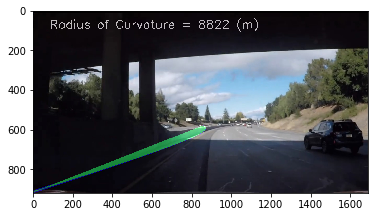

In [8]:
plt.imshow(pipeline(mpimg.imread('test5.jpg')))

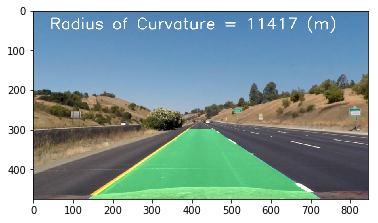

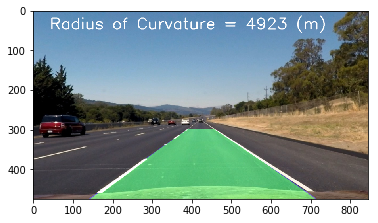

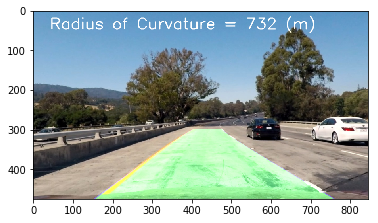

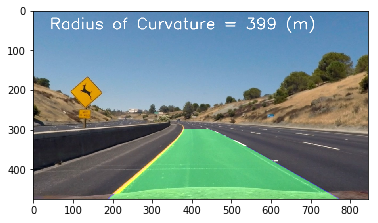

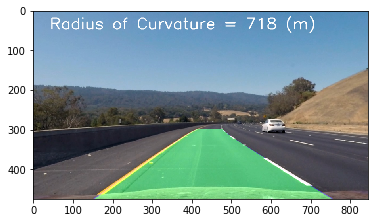

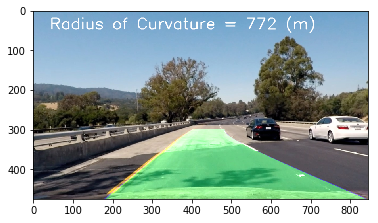

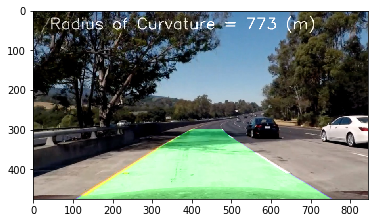

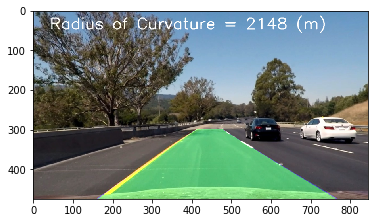

In [19]:
img_list = sorted(glob.glob('test_images/*.jpg'))

for img_fp in img_list:
    img = mpimg.imread(img_fp)
    if hasattr(pipeline, 'img_size'):
        del pipeline.img_size
        pass
    out = pipeline(img)
    plt.imshow(out)
    plt.show()

In [20]:
project_video = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
clip1_out = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_out.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [17:15<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 38min 31s, sys: 4min 5s, total: 42min 36s
Wall time: 17min 16s


In [823]:
del clip1_out, clip1

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video))

In [71]:
challenge_video = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
clip2_out = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip2_out.write_videofile(challenge_video, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4



 64%|██████▎   | 309/485 [05:11<01:59,  1.47it/s]


100%|██████████| 485/485 [07:48<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 15min 50s, sys: 2min 11s, total: 18min 1s
Wall time: 7min 49s


In [72]:
harder_challenge_video = 'output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
if hasattr(pipeline, 'img_size'):
    del pipeline.img_size
clip3_out = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip3_out.write_videofile(harder_challenge_video, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4



 25%|██▌       | 303/1200 [09:32<32:37,  2.18s/it]


 50%|█████     | 605/1200 [18:14<08:07,  1.22it/s]


 76%|███████▌  | 907/1200 [25:54<05:14,  1.07s/it]


100%|█████████▉| 1199/1200 [32:06<00:02,  2.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 1h 12min 41s, sys: 4min 5s, total: 1h 16min 46s
Wall time: 32min 6s
